In [101]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from pandas_market_calendars import get_calendar
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import os
from pathlib import Path
import sys
import re
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb

In [102]:
# Add the project root directory to Python path
project_root = Path(r'C:\Users\marwi\PycharmProjects\selling-volatility')
sys.path.append(str(project_root))

from config import settings

In [103]:
# Strategy parameters
polygon_api_key = settings.POLYGON.API_KEY
calendar = get_calendar("NYSE")
trading_dates = calendar.schedule(start_date="2023-05-01",
                                end_date=(datetime.today() - timedelta(days=1))).index.strftime("%Y-%m-%d").values

ticker = "I:SPX"
index_ticker = "I:VIX1D"
options_ticker = "SPX"
etf_ticker = "SPY"

trade_time = "09:35"
move_adjustment = .5
spread_width = 1

In [104]:
# Data Collection
# Define data directory paths
BASE_DATA_DIR = Path(r"C:\Users\marwi\PycharmProjects\selling-volatility\data")
SPX_DIR = BASE_DATA_DIR / "I_SPX"
VIX_DIR = BASE_DATA_DIR / "I_VIX1D"
SPY_DIR = BASE_DATA_DIR / "SPY"

# Ensure directories exist and create them if they don't
for dir_path in [SPX_DIR, VIX_DIR, SPY_DIR]:
    dir_path.mkdir(parents=True, exist_ok=True)

def get_file_path(ticker, date, interval):
    """Generate file path based on ticker, date and interval."""
    base_dir = {
        "I:SPX": SPX_DIR,
        "I:VIX1D": VIX_DIR,
        "SPY": SPY_DIR
    }[ticker]

    return base_dir / f"{date}_{interval}_aggs.csv"

def check_file_exists(file_path):
    """Check if file exists and is not empty."""
    return file_path.exists() and file_path.stat().st_size > 0

def fetch_and_save_data(ticker, date, interval, api_key):
    """Fetch data from Polygon API and save to CSV."""
    file_path = get_file_path(ticker, date, interval)

    try:
        if check_file_exists(file_path):
            df = pd.read_csv(file_path)
            if df.empty:
                return pd.DataFrame()

            # If timestamp is already in datetime format (checking for both EDT and EST)
            if isinstance(df['t'].iloc[0], str) and ('-04:00' in df['t'].iloc[0] or '-05:00' in df['t'].iloc[0]):
                df.set_index(pd.to_datetime(df['t']), inplace=True)
            else:
                # If timestamp is in milliseconds
                df.set_index(pd.to_datetime(df['t'], unit='ms', utc=True).tz_convert("America/New_York"), inplace=True)

            return df

        # Fetching new data from API
        url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/1/{interval}/{date}/{date}?adjusted=true&sort=asc&limit=50000&apiKey={api_key}"

        response = requests.get(url)
        if response.status_code != 200:
            return pd.DataFrame()

        data = pd.json_normalize(response.json()["results"])
        if data.empty:
            return pd.DataFrame()

        # Convert millisecond timestamps for new API data
        data.set_index(pd.to_datetime(data['t'], unit='ms', utc=True).tz_convert("America/New_York"), inplace=True)

        # Save to CSV
        data.to_csv(file_path)
        return data

    except Exception as e:
        print(f"Error in fetch_and_save_data for {ticker} on {date}: {str(e)}")
        return pd.DataFrame()


def collect_data_parallel(dates, polygon_api_key):
    """
    Parallel data collection for multiple dates
    Returns a dictionary of DataFrames indexed by date
    """
    def process_single_date(date):
        try:
            prior_day = trading_dates[np.where(trading_dates == date)[0][0] - 1]

            # Create a dictionary to store all data for this date
            date_data = {}

            # Fetch all required data
            tasks = [
                ("I:SPX", prior_day, "day"),
                ("I:SPX", date, "minute"),
                ("I:VIX1D", date, "minute"),
                ("SPY", date, "minute"),
                ("SPY", "2020-01-01", prior_day, "day")
            ]

            for task in tasks:
                if len(task) == 3:
                    ticker, task_date, interval = task
                    key = f"{ticker}_{interval}_{task_date}"
                    data = fetch_and_save_data(ticker, task_date, interval, polygon_api_key)
                    if data.empty:
                        return None  # Return None instead of error string
                    date_data[key] = data
                else:
                    ticker, start_date, end_date, interval = task
                    key = f"{ticker}_{interval}_historical"
                    file_path = BASE_DATA_DIR / f"{ticker}_historical_{end_date}.csv"

                    if not check_file_exists(file_path):
                        url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/1/{interval}/{start_date}/{end_date}?adjusted=true&sort=asc&limit=50000&apiKey={polygon_api_key}"
                        response = requests.get(url)
                        if 'results' not in response.json():
                            return None  # Return None instead of error string
                        data = pd.json_normalize(response.json()["results"])
                        data.to_csv(file_path)
                        date_data[key] = data
                    else:
                        date_data[key] = pd.read_csv(file_path)

            return date_data  # Return the data dictionary directly

        except Exception as e:
            print(f"Error processing {date}: {str(e)}")
            return None  # Return None instead of error string

    # Create progress bar
    pbar = tqdm(total=len(dates), desc="Collecting data")
    results = {}

    # Use ThreadPoolExecutor for parallel processing
    with ThreadPoolExecutor(max_workers=5) as executor:
        future_to_date = {executor.submit(process_single_date, date): date for date in dates}

        for future in as_completed(future_to_date):
            date = future_to_date[future]
            try:
                data = future.result()
                if data is not None:  # Only store valid data
                    results[date] = data
                pbar.update(1)
            except Exception as e:
                print(f"Error processing {date}: {str(e)}")

    pbar.close()
    return results

In [105]:
def fetch_option_quotes(option_ticker, quote_timestamp, close_timestamp, polygon_api_key):
    """Fetch option quotes for a specific option contract."""
    url = f"https://api.polygon.io/v3/quotes/{option_ticker}?timestamp.gte={quote_timestamp}&timestamp.lt={close_timestamp}&order=asc&limit=5000&sort=timestamp&apiKey={polygon_api_key}"

    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f"Failed to fetch option quotes for {option_ticker}")

    quotes = pd.json_normalize(response.json()["results"])
    quotes.set_index("sip_timestamp", inplace=True)
    quotes.index = pd.to_datetime(quotes.index, unit="ns", utc=True).tz_convert("America/New_York")
    quotes["mid_price"] = round((quotes["bid_price"] + quotes["ask_price"]) / 2, 2)

    return quotes

In [106]:
def create_features_and_execute_trade(date, collected_data, polygon_api_key):
    try:
        prior_day = trading_dates[np.where(trading_dates == date)[0][0] - 1]

        # Get the data we need from our collected_data
        prior_day_data = collected_data[date][f"I:SPX_day_{prior_day}"].copy()
        current_day_spx = collected_data[date][f"I:SPX_minute_{date}"].copy()
        current_day_vix = collected_data[date][f"I:VIX1D_minute_{date}"].copy()
        current_day_spy = collected_data[date][f"SPY_minute_{date}"].copy()
        historical_spy = collected_data[date]["SPY_day_historical"].copy()

        # Reset indices to datetime
        for df in [prior_day_data, current_day_spx, current_day_vix, current_day_spy]:
            df.index = pd.to_datetime(df.index)

        # For historical_spy, handle differently as it might have 't' column
        if 't' in historical_spy.columns:
            historical_spy.set_index('t', inplace=True)
        historical_spy.index = pd.to_datetime(historical_spy.index)

        # Filter for trade time
        current_day_spy = current_day_spy[current_day_spy.index.time >= pd.Timestamp(trade_time).time()].copy()
        current_day_spx = current_day_spx[
            (current_day_spx.index.time >= pd.Timestamp(trade_time).time()) &
            (current_day_spx.index.time <= pd.Timestamp("16:00").time())
        ].copy()
        current_day_vix = current_day_vix[current_day_vix.index.time >= pd.Timestamp(trade_time).time()].copy()

        # Add error checking for empty dataframes
        if (current_day_spy.empty or current_day_spx.empty or current_day_vix.empty):
            raise ValueError(f"Empty data for {date} after filtering for trade time")

        # Calculate required values
        prior_day_price = prior_day_data["c"].iloc[0]
        index_price = current_day_vix["c"].iloc[0]
        price = current_day_spx["c"].iloc[0]
        closing_value = current_day_spx["c"].iloc[-1]

        overnight_move = round(((price - prior_day_price) / prior_day_price) * 100, 2)
        expected_move = (round((index_price / np.sqrt(252)), 2) / 100) * move_adjustment

        # Calculate regime
        concatenated_regime_dataset = pd.concat([historical_spy, current_day_spy.head(1)], axis=0)
        concatenated_regime_dataset["1_mo_avg"] = concatenated_regime_dataset["c"].rolling(window=20).mean()
        concatenated_regime_dataset["3_mo_avg"] = concatenated_regime_dataset["c"].rolling(window=60).mean()

        # Execute trade based on direction
        direction = 1 if (concatenated_regime_dataset["c"] > concatenated_regime_dataset["1_mo_avg"]).iloc[-1] else 0

        # Execute the trade
        trade_result = execute_trade(date, direction, price, expected_move, closing_value, polygon_api_key)

        if trade_result is None:
            raise ValueError(f"Trade execution failed for {date}")

        # Create feature set
        features = {
            'overnight_move': overnight_move,
            'index_price': index_price,
            'expected_move': expected_move,
            'price_vs_1mo': price > concatenated_regime_dataset["1_mo_avg"].iloc[-1],
            'price_vs_3mo': price > concatenated_regime_dataset["3_mo_avg"].iloc[-1],
            'vix_level': index_price,
            'prior_day_price': prior_day_price
        }

        # Target variable (1 for profitable trade, 0 for loss)
        target = 1 if trade_result['gross_pnl'] > 0 else 0

        return features, target, trade_result

    except Exception as e:
        print(f"Error creating features for {date}: {str(e)}")
        return None, None, None

In [107]:
def execute_trade(date, direction, price, expected_move, closing_value, polygon_api_key):
    """Execute trade and return trade results"""
    try:
        lower_price = round(price - (price * expected_move))
        upper_price = round(price + (price * expected_move))
        exp_date = date
        minute_timestamp = (pd.to_datetime(date).tz_localize("America/New_York") + timedelta(
            hours=pd.Timestamp(trade_time).time().hour, minutes=pd.Timestamp(trade_time).time().minute))
        quote_timestamp = minute_timestamp.value
        close_timestamp = (pd.to_datetime(date).tz_localize("America/New_York") + timedelta(hours=16, minutes=0)).value

        if direction == 0:  # Call spread
            valid_calls = pd.json_normalize(requests.get(
                f"https://api.polygon.io/v3/reference/options/contracts?underlying_ticker={options_ticker}&contract_type=call&as_of={date}&expiration_date={exp_date}&limit=1000&apiKey={polygon_api_key}").json()["results"])
            valid_calls = valid_calls[valid_calls["ticker"].str.contains("SPXW")].copy()
            valid_calls["strike_price"] = valid_calls["strike_price"].astype(float)
            otm_calls = valid_calls[valid_calls["strike_price"] >= upper_price]

            short_call = otm_calls.iloc[[0]]
            long_call = otm_calls.iloc[[spread_width]]

            short_strike = short_call["strike_price"].iloc[0]

            # Fetch quotes
            short_quotes = fetch_option_quotes(short_call['ticker'].iloc[0], quote_timestamp, close_timestamp, polygon_api_key)
            long_quotes = fetch_option_quotes(long_call['ticker'].iloc[0], quote_timestamp, close_timestamp, polygon_api_key)

            # Calculate spread value
            short_quote = short_quotes[short_quotes.index.strftime("%Y-%m-%d %H:%M") <= minute_timestamp.strftime("%Y-%m-%d %H:%M")].median()
            long_quote = long_quotes[long_quotes.index.strftime("%Y-%m-%d %H:%M") <= minute_timestamp.strftime("%Y-%m-%d %H:%M")].median()

            cost = short_quote['mid_price'] - long_quote['mid_price']
            max_loss = abs(short_call["strike_price"].iloc[0] - long_call["strike_price"].iloc[0]) - cost

        else:  # Put spread
            valid_puts = pd.json_normalize(requests.get(
                f"https://api.polygon.io/v3/reference/options/contracts?underlying_ticker={options_ticker}&contract_type=put&as_of={date}&expiration_date={exp_date}&limit=1000&apiKey={polygon_api_key}").json()["results"])
            valid_puts = valid_puts[valid_puts["ticker"].str.contains("SPXW")].copy()
            valid_puts["strike_price"] = valid_puts["strike_price"].astype(float)
            otm_puts = valid_puts[valid_puts["strike_price"] <= lower_price].sort_values("strike_price", ascending=False)

            short_put = otm_puts.iloc[[0]]
            long_put = otm_puts.iloc[[spread_width]]

            short_strike = short_put["strike_price"].iloc[0]

            # Fetch quotes
            short_quotes = fetch_option_quotes(short_put['ticker'].iloc[0], quote_timestamp, close_timestamp, polygon_api_key)
            long_quotes = fetch_option_quotes(long_put['ticker'].iloc[0], quote_timestamp, close_timestamp, polygon_api_key)

            # Calculate spread value
            short_quote = short_quotes[short_quotes.index.strftime("%Y-%m-%d %H:%M") <= minute_timestamp.strftime("%Y-%m-%d %H:%M")].median()
            long_quote = long_quotes[long_quotes.index.strftime("%Y-%m-%d %H:%M") <= minute_timestamp.strftime("%Y-%m-%d %H:%M")].median()

            cost = short_quote['mid_price'] - long_quote['mid_price']
            max_loss = abs(short_put["strike_price"].iloc[0] - long_put["strike_price"].iloc[0]) - cost

        # Calculate PnL
        if direction == 1:
            settlement = closing_value - short_strike
            final_pnl = settlement + cost if settlement < 0 else cost
        else:
            settlement = short_strike - closing_value
            final_pnl = settlement + cost if settlement < 0 else cost

        gross_pnl = np.maximum(final_pnl, max_loss * -1)
        gross_pnl_percent = round((gross_pnl / cost) * 100, 2)

        contracts = 1
        fees = contracts * 0.04
        net_pnl = (gross_pnl * contracts) - fees

        return {
            'date': date,
            'cost': cost,
            'gross_pnl': gross_pnl,
            'gross_pnl_percent': gross_pnl_percent,
            'direction': direction,
            'short_strike': short_strike,
            'closing_value': closing_value,
            'contracts': contracts,
            'fees': fees,
            'net_pnl': net_pnl
        }

    except Exception as e:
        print(f"Error executing trade for {date}: {str(e)}")
        return None

In [108]:
def run_backtest_with_ml():
    """Main function to run backtest and prepare ML data"""
    # Collect all required data
    collected_data = collect_data_parallel(trading_dates[1:], polygon_api_key)

    features_list = []
    targets_list = []
    trade_results = []

    # Process each date
    for date in tqdm(trading_dates[1:], desc="Processing trades"):
        if date not in collected_data:  # Skip dates with missing data
            print(f"Skipping {date} - no data available")
            continue

        features, target, trade_result = create_features_and_execute_trade(date, collected_data, polygon_api_key)

        if all(v is not None for v in [features, target, trade_result]):
            features_list.append(features)
            targets_list.append(target)
            trade_results.append(trade_result)

    if not features_list:
        raise ValueError("No valid trades were processed. Check the data collection and processing steps.")

    # Convert to DataFrames
    X = pd.DataFrame(features_list)
    y = np.array(targets_list)
    trades_df = pd.DataFrame(trade_results)

    # Calculate net capital
    initial_capital = 3000
    trades_df['net_capital'] = initial_capital + (trades_df['net_pnl'] * 100).cumsum()

    print(f"Processed {len(features_list)} valid trades out of {len(trading_dates[1:])} total dates")

    return X, y, trades_df

In [109]:
def backtest_ml_strategy(model, X, initial_capital=3000):
    """
    Backtest an ML model's performance

    Parameters:
    model: trained ML model
    X: scaled feature matrix
    initial_capital: starting capital

    Returns:
    DataFrame with trading results
    """
    predictions = model.predict(X)

    trades = pd.DataFrame({
        'prediction': predictions,
        'actual_return': y  # Using actual returns from your original data
    }, index=all_trades.index)  # Use the same index as all_trades for alignment

    trades['pnl'] = trades.apply(lambda row:
        all_trades.loc[row.name, 'net_pnl'] if row['prediction'] == 1 else 0, axis=1)

    trades['cumulative_pnl'] = initial_capital + (trades['pnl'] * 100).cumsum()

    return trades

Error in fetch_and_save_data for I:SPX on 2024-08-05: 'results'


Error in fetch_and_save_data for I:SPX on 2024-10-08: 'results'


Error in fetch_and_save_data for I:SPX on 2024-12-06: 'results'


Error in fetch_and_save_data for I:SPX on 2025-01-09: 'results'
Error in fetch_and_save_data for I:SPX on 2025-01-09: 'results'


Error in fetch_and_save_data for I:SPX on 2025-03-05: 'results'


Processing trades:   8%|▊         | 38/470 [02:22<18:01,  2.50s/it]

Error executing trade for 2023-06-26: 'ticker'
Error creating features for 2023-06-26: Trade execution failed for 2023-06-26


Processing trades:   8%|▊         | 39/470 [02:22<13:53,  1.93s/it]

Error executing trade for 2023-06-27: 'ticker'
Error creating features for 2023-06-27: Trade execution failed for 2023-06-27


Processing trades:   9%|▊         | 40/470 [02:23<10:48,  1.51s/it]

Error executing trade for 2023-06-28: 'ticker'
Error creating features for 2023-06-28: Trade execution failed for 2023-06-28


Processing trades:   9%|▊         | 41/470 [02:23<08:38,  1.21s/it]

Error executing trade for 2023-06-29: 'ticker'
Error creating features for 2023-06-29: Trade execution failed for 2023-06-29


Processing trades:   9%|▉         | 42/470 [02:24<07:20,  1.03s/it]

Error executing trade for 2023-06-30: 'ticker'
Error creating features for 2023-06-30: Trade execution failed for 2023-06-30


Processing trades:  67%|██████▋   | 316/470 [20:00<08:15,  3.22s/it]

Skipping 2024-08-05 - no data available


Processing trades:  77%|███████▋  | 361/470 [22:40<05:38,  3.10s/it]

Skipping 2024-10-08 - no data available


Processing trades:  86%|████████▌ | 403/470 [26:11<06:39,  5.96s/it]

Skipping 2024-12-06 - no data available


Processing trades:  90%|█████████ | 425/470 [28:01<03:25,  4.56s/it]

Skipping 2025-01-09 - no data available
Skipping 2025-01-10 - no data available


Processing trades:  98%|█████████▊| 462/470 [30:22<00:31,  3.99s/it]

Skipping 2025-03-05 - no data available


Processing trades: 100%|██████████| 470/470 [30:54<00:00,  3.95s/it]


Processed 459 valid trades out of 470 total dates
Shape of features matrix: (459, 7)
Number of trades: 459

Gaussian NB Performance:
              precision    recall  f1-score   support

           0       0.27      0.12      0.17        25
           1       0.73      0.88      0.80        67

    accuracy                           0.67        92
   macro avg       0.50      0.50      0.48        92
weighted avg       0.60      0.67      0.63        92


Random Forest Performance:
              precision    recall  f1-score   support

           0       0.27      0.12      0.17        25
           1       0.73      0.88      0.80        67

    accuracy                           0.67        92
   macro avg       0.50      0.50      0.48        92
weighted avg       0.60      0.67      0.63        92


Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        25
           1       0.73      1.00      0.8

c:\Users\marwi\miniconda3\envs\selling_volatility\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\marwi\miniconda3\envs\selling_volatility\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\marwi\miniconda3\envs\selling_volatility\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

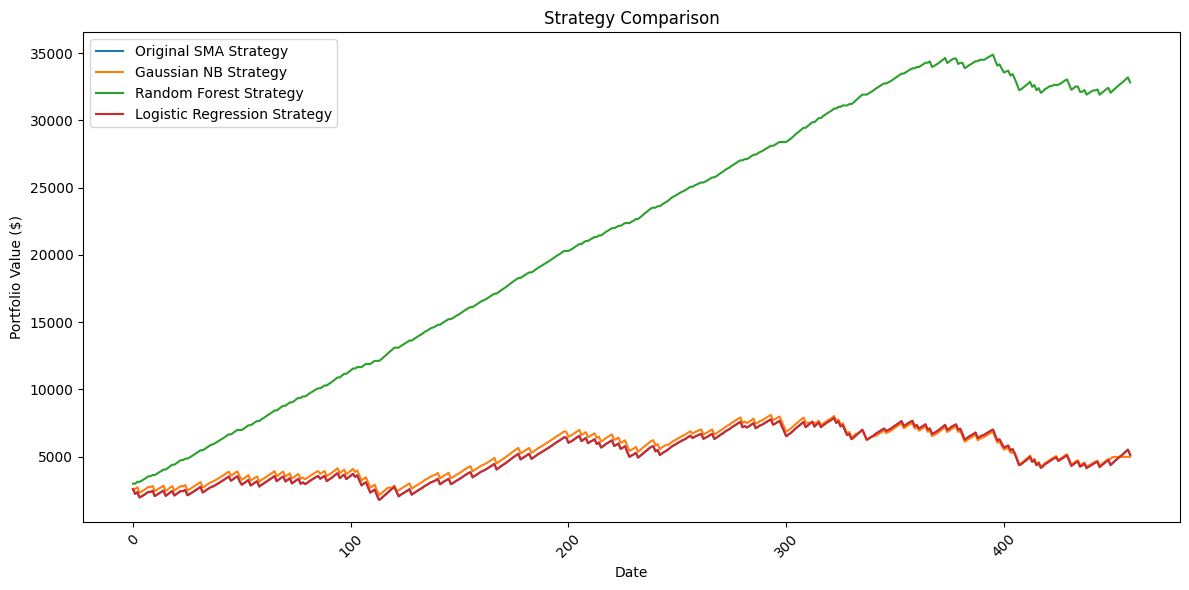


Performance Metrics:
SMA Strategy Final Capital: $5141.00
Gaussian NB Final Capital: $4988.00
Random Forest Final Capital: $32808.00
Logistic Regression Final Capital: $5141.00


In [127]:
# Main execution
if __name__ == "__main__":
    # Run backtest and get ML data
    X, y, all_trades = run_backtest_with_ml()

    print(f"Shape of features matrix: {X.shape}")
    print(f"Number of trades: {len(all_trades)}")

    # Convert boolean features to int for ML
    bool_columns = X.select_dtypes(include=['bool']).columns
    X[bool_columns] = X[bool_columns].astype(int)

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train and evaluate models
    models = {
        'Gaussian NB': GaussianNB(),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Logistic Regression': LogisticRegression(random_state=42)
    }

    results = {}
    for name, model in models.items():
        # Train model
        model.fit(X_train_scaled, y_train)

        # Get predictions
        predictions = model.predict(X_test_scaled)
        print(f"\n{name} Performance:")
        print(classification_report(y_test, predictions))

        # Backtest the model
        results[name] = backtest_ml_strategy(model, scaler.transform(X), initial_capital=3000)

    # Visualization
    plt.figure(figsize=(12, 6))
    plt.plot(all_trades.index, all_trades['net_capital'], label='Original SMA Strategy')

    for name, result in results.items():
        plt.plot(all_trades.index, result['cumulative_pnl'], label=f'{name} Strategy')

    plt.title('Strategy Comparison')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value ($)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Print performance metrics
    print("\nPerformance Metrics:")
    print(f"SMA Strategy Final Capital: ${all_trades['net_capital'].iloc[-1]:.2f}")
    for name, result in results.items():
        print(f"{name} Final Capital: ${result['cumulative_pnl'].iloc[-1]:.2f}")

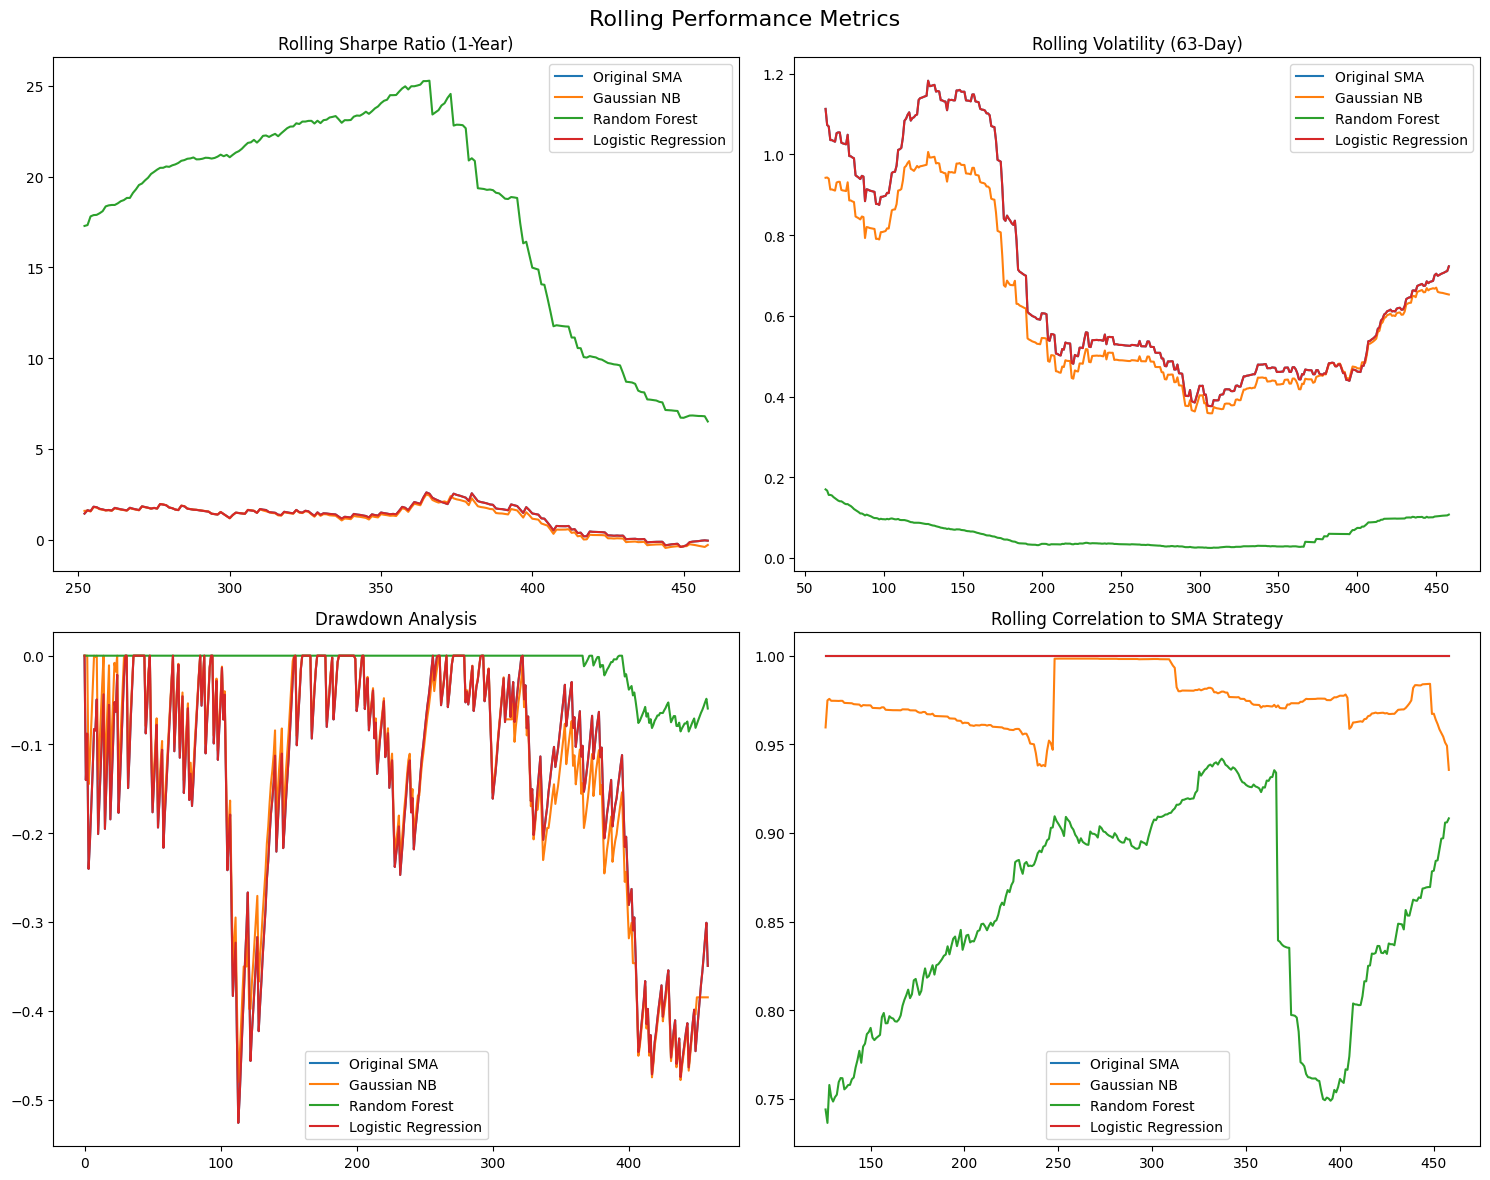

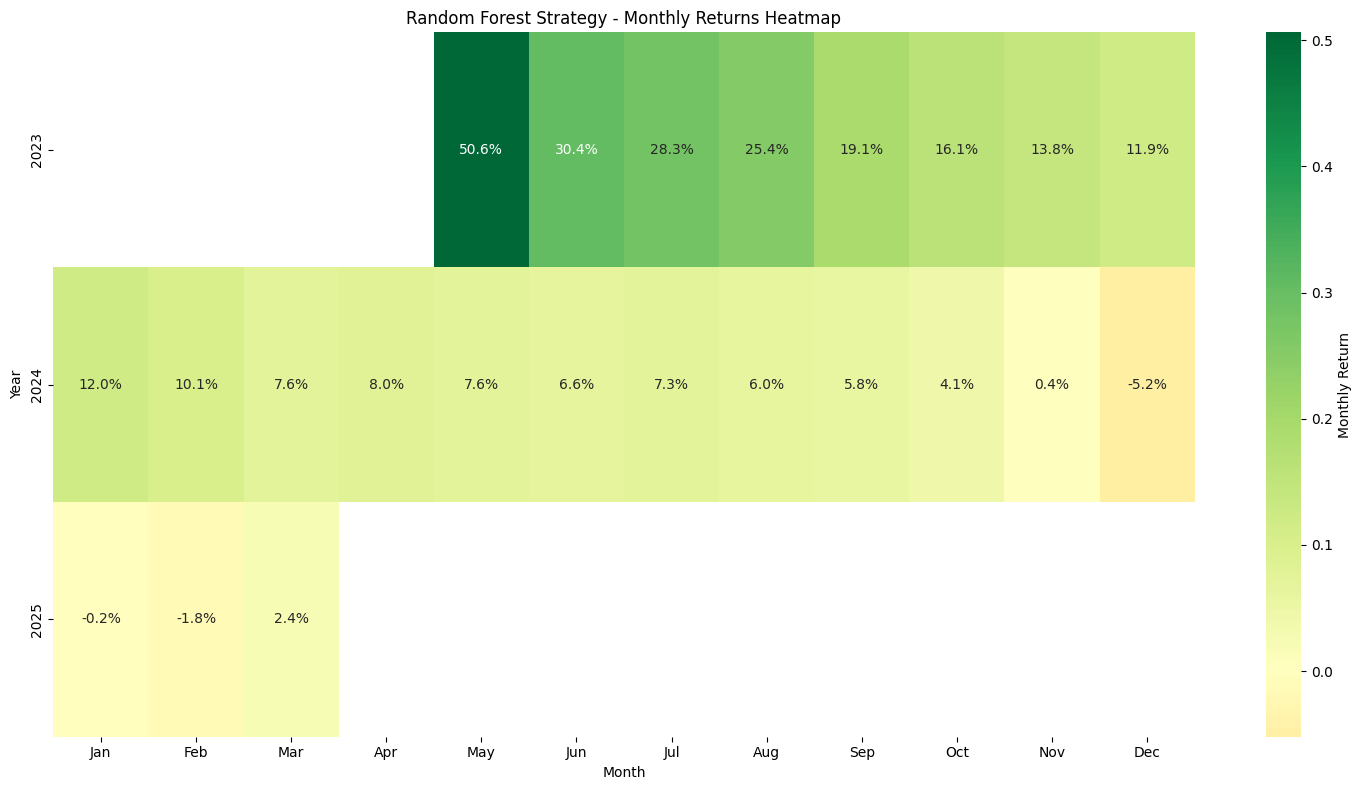


Monthly Return Statistics:
Average Monthly Return: 11.4%
Best Month: 50.6%
Worst Month: -5.2%
% Positive Months: 55.6%

Detailed Performance Metrics:
                   Original SMA  Gaussian NB  Random Forest  \
Annual Return             0.455        0.431          2.718   
Annual Volatility         0.767        0.674          0.118   
Sharpe Ratio              0.593        0.639         23.081   
Max Drawdown             -0.526       -0.480         -0.085   
Calmar Ratio              0.864        0.897         31.812   
Total Return              0.979        0.920          9.936   

                   Logistic Regression  
Annual Return                    0.455  
Annual Volatility                0.767  
Sharpe Ratio                     0.593  
Max Drawdown                    -0.526  
Calmar Ratio                     0.864  
Total Return                     0.979  

Risk Metrics for Random Forest Strategy:
Daily Value at Risk (95%): 0.00%
Daily Expected Shortfall (95%): -0.23%
Win Ra

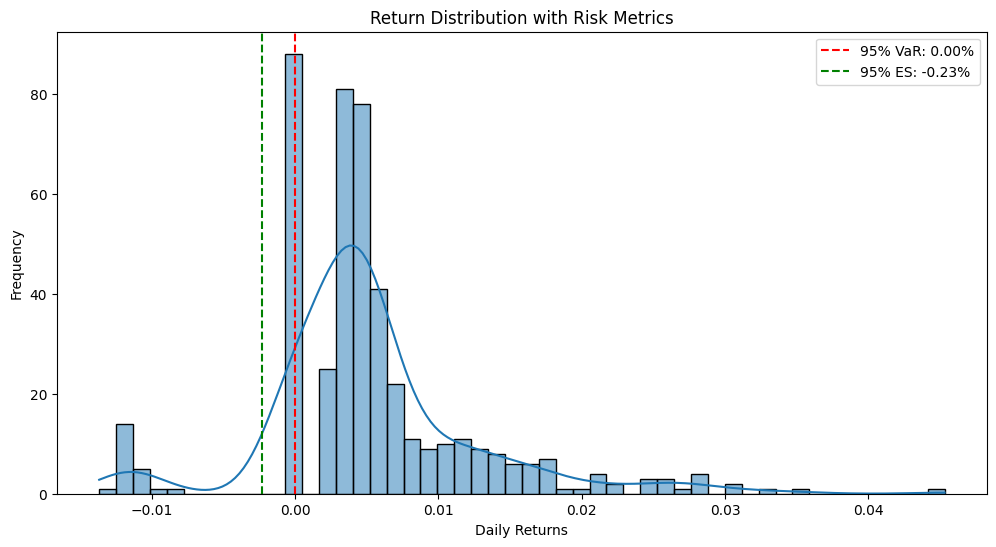


Trade Statistics:
Number of Trades: 459
Win Rate: 77.6%
Average Winner: $109.22
Average Loser: $-356.73

Strategy Consistency Metrics:
% of Positive Months: 87.0%
Worst Month: -5.2%
Best Month: 50.6%
Average Monthly Return: 11.6%
Monthly Return Std Dev: 12.5%

Consistency Metrics:
Longest Winning Streak: 15 days
Longest Losing Streak: 3 days
Percent Profitable Days: 76.0%


<Figure size 1200x600 with 0 Axes>

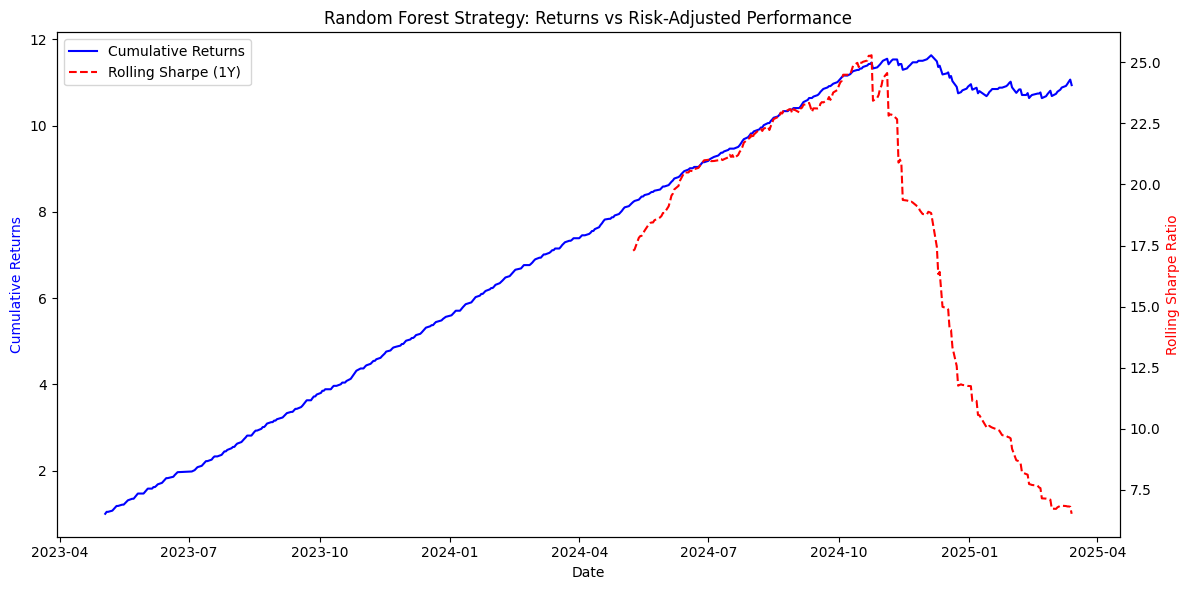


Additional Risk Metrics:
Annualized Volatility: 11.8%
Maximum Drawdown: -8.5%
Sortino Ratio: 81.05
Calmar Ratio: 15.52


In [128]:
# Additional Analysis for QIS Pitch

# 1. Calculate daily returns and key performance metrics
def calculate_performance_metrics(equity_curve):
    daily_returns = equity_curve.pct_change()
    annual_return = (1 + daily_returns).prod() ** (252/len(daily_returns)) - 1
    volatility = daily_returns.std() * np.sqrt(252)
    sharpe_ratio = annual_return / volatility
    max_drawdown = (equity_curve / equity_curve.cummax() - 1).min()
    calmar_ratio = annual_return / abs(max_drawdown)

    return {
        'Annual Return': annual_return,
        'Annual Volatility': volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown,
        'Calmar Ratio': calmar_ratio,
        'Total Return': (equity_curve.iloc[-1] / equity_curve.iloc[0]) - 1
    }

# Calculate metrics for all strategies
strategies = {
    'Original SMA': all_trades['net_capital'],
    'Gaussian NB': results['Gaussian NB']['cumulative_pnl'],
    'Random Forest': results['Random Forest']['cumulative_pnl'],
    'Logistic Regression': results['Logistic Regression']['cumulative_pnl']
}

metrics_df = pd.DataFrame({name: calculate_performance_metrics(equity)
                         for name, equity in strategies.items()}).round(3)

# 2. Create a rolling metrics visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Rolling Performance Metrics', fontsize=16)

# Rolling Sharpe Ratio (252-day)
rolling_returns = pd.DataFrame({name: equity.pct_change()
                              for name, equity in strategies.items()})
rolling_sharpe = (rolling_returns.rolling(252).mean() /
                 rolling_returns.rolling(252).std()) * np.sqrt(252)
rolling_sharpe.plot(ax=axes[0,0], title='Rolling Sharpe Ratio (1-Year)')

# Rolling Volatility
rolling_vol = rolling_returns.rolling(63).std() * np.sqrt(252)
rolling_vol.plot(ax=axes[0,1], title='Rolling Volatility (63-Day)')

# Drawdown Analysis
drawdowns = pd.DataFrame({name: equity / equity.cummax() - 1
                         for name, equity in strategies.items()})
drawdowns.plot(ax=axes[1,0], title='Drawdown Analysis')

# Rolling Beta to S&P 500 (if available, otherwise use another benchmark)
rolling_correlation = rolling_returns.rolling(126).corr(rolling_returns['Original SMA'])
rolling_correlation.plot(ax=axes[1,1], title='Rolling Correlation to SMA Strategy')

plt.tight_layout()
plt.show()

# 3. Monthly Returns Heatmap (focusing on Random Forest as best performer)
# Convert index to datetime and ensure it's using the correct dates
rf_returns = strategies['Random Forest'].pct_change()
rf_returns.index = pd.to_datetime(all_trades['date'])  # Use the actual dates from all_trades

# Create monthly returns
monthly_returns = pd.DataFrame(index=rf_returns.index)
monthly_returns['returns'] = rf_returns
monthly_returns['year'] = monthly_returns.index.year
monthly_returns['month'] = monthly_returns.index.month

# Calculate monthly returns
monthly_pivot = monthly_returns.groupby(['year', 'month'])['returns'].apply(
    lambda x: (1 + x).prod() - 1).unstack('month')

# Rename columns to month names
month_names = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
    7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}
monthly_pivot = monthly_pivot.rename(columns=month_names)

# Create heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(monthly_pivot,
            annot=True,
            fmt='.1%',
            cmap='RdYlGn',
            center=0,
            cbar_kws={'label': 'Monthly Return'},
            yticklabels=monthly_pivot.index)

plt.title('Random Forest Strategy - Monthly Returns Heatmap')
plt.xlabel('Month')
plt.ylabel('Year')
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nMonthly Return Statistics:")
print(f"Average Monthly Return: {monthly_pivot.mean().mean():.1%}")
print(f"Best Month: {monthly_pivot.max().max():.1%}")
print(f"Worst Month: {monthly_pivot.min().min():.1%}")
print(f"% Positive Months: {(monthly_pivot > 0).mean().mean():.1%}")

# 4. Print detailed statistics
print("\nDetailed Performance Metrics:")
print(metrics_df)

# 5. Risk Analysis
print("\nRisk Metrics for Random Forest Strategy:")

# Calculate daily returns properly
rf_strategy = strategies['Random Forest']
rf_returns = rf_strategy.pct_change().dropna()  # Remove any NaN values

# Calculate VaR and ES using actual returns distribution
var_95 = np.percentile(rf_returns, 5)  # 95% VaR (using 5th percentile of returns)
es_95 = rf_returns[rf_returns <= var_95].mean()  # Expected Shortfall

# Calculate win rate and profit metrics using trade results
winning_trades = all_trades[all_trades['net_pnl'] > 0]
losing_trades = all_trades[all_trades['net_pnl'] < 0]
win_rate = len(winning_trades) / len(all_trades)

profit_factor = abs(winning_trades['net_pnl'].sum() / losing_trades['net_pnl'].sum())

print(f"Daily Value at Risk (95%): {var_95:.2%}")
print(f"Daily Expected Shortfall (95%): {es_95:.2%}")
print(f"Win Rate: {win_rate:.1%}")
print(f"Profit Factor: {profit_factor:.2f}")


# Plot return distribution
plt.figure(figsize=(12, 6))
sns.histplot(rf_returns, bins=50, kde=True)
plt.axvline(var_95, color='r', linestyle='--', label=f'95% VaR: {var_95:.2%}')
plt.axvline(es_95, color='g', linestyle='--', label=f'95% ES: {es_95:.2%}')
plt.title('Return Distribution with Risk Metrics')
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# 6. Trade Analysis
print("\nTrade Statistics:")
print(f"Number of Trades: {len(all_trades)}")
print(f"Win Rate: {(all_trades['net_pnl'] > 0).mean():.1%}")
print(f"Average Winner: ${(all_trades[all_trades['net_pnl'] > 0]['net_pnl'].mean() * 100):.2f}")
print(f"Average Loser: ${(all_trades[all_trades['net_pnl'] < 0]['net_pnl'].mean() * 100):.2f}")

# 7. Strategy Consistency Metrics
print("\nStrategy Consistency Metrics:")

# Ensure we're using the correct dates and lengths match
rf_strategy = strategies['Random Forest']
rf_returns = rf_strategy.pct_change().dropna()  # Remove any NaN values from the first calculation

# Set proper datetime index using all_trades['date']
rf_returns.index = pd.to_datetime(all_trades['date'].iloc[1:])  # Skip first row since we lost it in pct_change()

# Create proper monthly returns
monthly_returns = rf_returns.groupby(pd.Grouper(freq='ME')).apply(lambda x: (1 + x).prod() - 1)

print(f"% of Positive Months: {(monthly_returns > 0).mean():.1%}")
print(f"Worst Month: {monthly_returns.min():.1%}")
print(f"Best Month: {monthly_returns.max():.1%}")
print(f"Average Monthly Return: {monthly_returns.mean():.1%}")
print(f"Monthly Return Std Dev: {monthly_returns.std():.1%}")

# Additional consistency metrics
from itertools import groupby  # Add this import if not already present
print("\nConsistency Metrics:")
print(f"Longest Winning Streak: {max((sum(1 for _ in g) for k, g in groupby(rf_returns > 0) if k), default=0)} days")
print(f"Longest Losing Streak: {max((sum(1 for _ in g) for k, g in groupby(rf_returns < 0) if k), default=0)} days")
print(f"Percent Profitable Days: {(rf_returns > 0).mean():.1%}")

# 8. Risk-Adjusted Returns Over Time
plt.figure(figsize=(12, 6))
cumulative_returns = (1 + rf_returns).cumprod()

# Create the dual-axis plot
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

# Plot cumulative returns on left axis
ax1.plot(cumulative_returns, 'b-', label='Cumulative Returns')

# Calculate and plot rolling Sharpe on right axis
rolling_sharpe_annual = (rf_returns.rolling(252).mean() /
                        rf_returns.rolling(252).std()) * np.sqrt(252)
ax2.plot(rolling_sharpe_annual, 'r--', label='Rolling Sharpe (1Y)')

# Labels and legend
ax1.set_xlabel('Date')
ax1.set_ylabel('Cumulative Returns', color='b')
ax2.set_ylabel('Rolling Sharpe Ratio', color='r')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title('Random Forest Strategy: Returns vs Risk-Adjusted Performance')
plt.tight_layout()
plt.show()

# 9. Additional Risk Metrics
print("\nAdditional Risk Metrics:")
# Calculate daily returns volatility
daily_vol = rf_returns.std() * np.sqrt(252)
print(f"Annualized Volatility: {daily_vol:.1%}")

# Calculate maximum drawdown
rolling_max = cumulative_returns.expanding().max()
drawdowns = cumulative_returns/rolling_max - 1
max_drawdown = drawdowns.min()
print(f"Maximum Drawdown: {max_drawdown:.1%}")

# Calculate Sortino Ratio (using 0% as minimum acceptable return)
negative_returns = rf_returns[rf_returns < 0]
downside_vol = negative_returns.std() * np.sqrt(252)
sortino_ratio = (rf_returns.mean() * 252) / downside_vol
print(f"Sortino Ratio: {sortino_ratio:.2f}")

# Calculate Calmar Ratio
calmar_ratio = (rf_returns.mean() * 252) / abs(max_drawdown)
print(f"Calmar Ratio: {calmar_ratio:.2f}")